# Introduction
Welcome to today's class on using Machine Learning (ML) in finance.
Today is when we finally get started with some predictive modelling!

## Agenda:
1. **Introduction to Machine Learning**  
2. **Building and evaluating classification models for risk assessment**  
3. **Balancing model accuracy and interpretability**   
4. **Handling Imbalanced Data**  
5. **Overfitting and cross-validation**   
6. **Assignment overview**  


Demo: Implementation in Python
------------------------------

### LendingClub Use Case


---



### Set up

#### User-specified parameters

In [1]:
python_material_folder_name = "python-material"


#### Import libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."

# 1. Introduction to Machine Learning

## 1.1 What is Machine Learning (ML)?
Machine Learning is a subset of artificial intelligence where algorithms learn from data to make predictions or decisions. In finance, use cases range from risk assessment, fraud detection, and investment management, among others.

## 1.2 Types of ML Algorithms
- **Supervised Learning**: The algorithm learns from labeled data (input-output pairs). e.g.: regression and classification.
- **Unsupervised Learning**: The algorithm identifies patterns from unlabeled data. e.g.: clustering and dimensionality reduction.
- **Reinforcement Learning**: The algorithm learns by interacting with an environment, maximizing cumulative rewards. e.g.: training an agent to trade stocks.

### Classification vs. Regression
- **Classification**: Predicts a discrete label (e.g., will a loan default? Yes or No).
- **Regression**: Predicts a continuous value (e.g., how much is customer X expected to borrow based on his characteristics?).




### <span style="color:BLUE"> **>>> DISCUSSION:**  </span>    
Match the following scenarios to the correct ML algorithm type (supervised, unsupervised, reinforcement).
- Grouping customers based on spending behavior.
- Training a robot to play a game.
- Predicting the price of a house.


## 1.3 How to choose the right algorithm?
Choosing the right machine learning algorithm can feel overwhelming, especially when you're just starting out.

## 1.3.1 Quick Workflow

1.  **Is your data labeled?**

    -   **Yes**: Supervised → Classification or Regression
    -   **No**: Unsupervised → Clustering or Dimensionality Reduction
    -   **Interaction with environment?** → Reinforcement Learning (rare)

2.  **What's your priority?**

    -   **Interpretability**: Start with Logistic Regression, Decision Trees
    -   **Accuracy**: Try Random Forest, Gradient Boosting, Neural Networks
    -   **Speed**: Consider simpler models like Logistic Regression or Decision Trees

3.  **Test and Compare**:
    -   Train multiple models and compare using metrics like accuracy, precision, recall, and F1-score.
    -   Use cross-validation to ensure your model performs well on unseen data.

## 1.3.2 Algo 'cheat sheet'
The cheat sheets at the link below will guide you through the process of selecting the appropriate algorithm based on the type of problem you are trying to solve and the nature of your data.

Example flowcharts covered in class:
- https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html
- https://learn.microsoft.com/en-us/azure/machine-learning/algorithm-cheat-sheet?view=azureml-api-1

A more relevant cheat sheet **based on the algorithms covered throughout this course** (and a few additional ones) can be found below:

| Algorithm                                        | Type                               | Best For                                               | Advantages                                                     | Disadvantages                                           | Covered in session |
| ------------------------------------------------ | ---------------------------------- | ------------------------------------------------------ | -------------------------------------------------------------- | ------------------------------------------------------- | ------------------ |
| Logistic Regression                              | Classification                     | Binary classification, Interpretability                | Simple, easy to interpret                                      | May underperform with complex data                      | 5                  |
| Linear Regression                                | Regression                         | Predicting continuous values                           | Simple, interpretable                                          | Sensitive to outliers, assumes linearity                | 5                  |
| Decision Trees                                   | Both                               | Interpretability, small to medium datasets             | Easy to visualize, no need for feature scaling                 | Prone to overfitting                                    | 6                  |
| Random Forest                                    | Both                               | Accuracy, handling missing data                        | Reduces overfitting, works well with large datasets            | Less interpretable, slower with large datasets          | 6                  |
| Gradient Boosting (XGBoost)                      | Both                               | Accuracy, complex datasets                             | High accuracy, handles mixed data types                        | Requires careful tuning, can overfit                    | 6                  |
| Support Vector Machine (SVM)                     | Both                               | High-dimensional data, text classification             | Effective in high dimensions, robust to outliers               | Requires feature scaling, slower on large datasets      | not covered        |
| K-Nearest Neighbors (KNN)                        | Both                               | Small datasets, non-linear data                        | Simple, no training phase                                      | Computationally expensive at prediction time            | 8                  |
| Naive Bayes                                      | Classification                     | Text data, high-dimensional data                       | Simple, fast, works well with small datasets                   | Assumes independence of features                        | not covered        |
| K-Means                                          | Clustering                         | Clustering, exploratory data analysis                  | Simple, fast                                                   | Sensitive to outliers, requires specifying clusters     | 8                  |
| Principal Component Analysis (PCA)               | Dimensionality Reduction           | Visualization, reducing feature set size               | Reduces dimensionality, improves computation speed             | Loses some interpretability                             | 8                  |
| Neural Networks                                  | Both                               | Large datasets, image data, complex patterns           | High accuracy, handles non-linear relationships                | Requires large datasets, computationally expensive      | 7                  |
| Convolutional Neural Networks (CNNs)             | Classification                     | Image data                                             | Excellent for image recognition tasks                          | Requires large datasets and computational resources     | 7                  |
| Long Short-Term Memory (LSTM)                    | Classification                     | Time series prediction, sequential data                | Captures long-term dependencies in sequential data             | Complex, requires large datasets, tuning is difficult   | 7                  |
| ARIMA (AutoRegressive Integrated Moving Average) | Forecasting                        | Time series forecasting                                | Effective for short-term forecasting, interpretable            | Assumes linearity, not suitable for non-stationary data | 9                  |
| Prophet                                          | Forecasting                        | Time series forecasting with seasonality               | Easy to use, handles missing data, seasonality                 | Limited customization, may not capture complex patterns | 9                  |
| Transformer-based LLMs (e.g., GPT, BERT)         | Language Modeling, Text Generation | Natural language processing, text generation, chatbots | Handles context, generates human-like text, versatile          | Requires massive datasets, high computational cost      | 10                 |
| Seq2Seq (Sequence to Sequence)                   | Language Modeling, Translation     | Language translation, text summarization               | Good for translation, summarization, uses attention mechanisms | May require large datasets, slower training             | 10                 |

## 1.3.3 Tips
-   **Start Simple**: Begin with simpler models and work your way up to more complex ones if needed.  
-   **Tune Hyperparameters**: Use techniques like GridSearchCV to find the best settings for your chosen model  
-   **Understand the Data**: Spend time understanding your data and the problem before jumping into complex algorithms.

## 1.4 Machine Learning Pipeline and Workflow - See slides

## 1.5. Introduction to Regression Models

Regression models are statistical techniques used to understand and predict relationships between variables. They help us quantify the relationship between one or more independent variables (predictors) and a dependent variable (outcome).

#### Key Concepts:

-   **Dependent Variable**: The outcome you're trying to predict (e.g., house price, stock returns).

-   **Independent Variables**: The inputs or features used to predict the dependent variable (e.g., number of rooms, location).

**Linear Regression** and **Logistic Regression** are two fundamental types of regression models:

1.  **Linear Regression** fits a linear relationship between the **continuouos** dependent variable and the independent variables.
2.  **Logistic Regression** dependent variable is **categorical** (often binary). Estimates the probability of a target class type based on the independent variables.

#### Key Differences:

-   **Output:**

    -   **Linear Regression:** Predicts continuous values (e.g., house prices, temperature).
    -   **Logistic Regression:** Predicts probabilities of binary outcomes (e.g., yes/no, spam/not spam).
-   **Function Form:**

    -   **Linear Regression:** Uses a linear equation (straight line) to model the relationship -> see [here](https://en.wikipedia.org/wiki/Linear_regression#/media/File:Linear_least_squares_example2.svg)
    -   **Logistic Regression:** Uses the logistic function (S-shaped curve) to model probabilities and constrain predictions between 0 and 1 -> see [here](https://en.wikipedia.org/wiki/File:Exam_pass_logistic_curve.svg) 
-   **Error Measurement:**

    -   **Linear Regression:** Evaluated using metrics like Mean Squared Error (MSE) or R-squared.
    -   **Logistic Regression:** Evaluated using classification metrics such as accuracy, precision, recall, and the ROC curve.
-   **Assumptions:**  

    - **Linearity**: Linear regression assumes linearity between predictors and the outcome, while logistic regression assumes linearity between predictors and the log-odds of the outcome.
    - **Normality of Errors**: Linear regression assumes normality of residuals; logistic regression does not require this.
    - **Homoscedasticity**: Linear regression assumes homoscedasticity (variance of the residuals should remain constant across all levels of the independent variables), while logistic regression does not.

#### Linear vs. logistic comparison:
- https://www.simplilearn.com/tutorials/machine-learning-tutorial/linear-regression-vs-logistic-regression (good intro)
- https://www.kdnuggets.com/2022/03/linear-logistic-regression-succinct-explanation.html (good introduction to formulas)
- https://en.wikipedia.org/wiki/Logistic_regression (provides more details on logistic function, which 'models the log-odds of an event as a linear combination of one or more independent variables').


# 2. Building Practical Classification Models for Risk Assessment

Let's build our first classification model using logistic regression, and following the **ML Pipeline and Workflow** covered in the slides for this session.


**Why Logistic Regression?**
- **Interpretability**: Each coefficient tells us how much the log odds of the outcome change with a unit increase in the predictor. It can be easily interpreted for % changes.
> Let's say you have a logistic regression model where the coefficient for a predictor variable X is 0.3  
> -> Odds Ratio = e^(0.3)≈1.35  
> -> i.e. a one-unit increase in X results in an approximately 35% increase in the odds of the outcome occurring.

- **Simplicity**: It requires fewer computational resources and is easy to implement.

More details [here](https://en.wikipedia.org/wiki/Logistic_regression)


##  2.1 Data Collection

#### Import data

In [3]:
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif3.csv")
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,debt_to_income,loan_amnt_log,grade_encoded,term_numeric,interest_per_loan_amnt,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,B5,cashier,10+ years,MORTGAGE,48000.0,Source Verified,Mar-2020,Current,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.950000,266.95,183.66,83.29,0.0,0.0,0.0,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,4.912140,134.93,167338079,cashier,False,NaN,NaN,0.1308,0.083333,8.294300,1,36,1569.6,-1.196895,-0.367206,0.083969,0.004364
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,B2,ABM,6 years,RENT,57000.0,Source Verified,Feb-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,708xx,LA,25.33,0.0,Jan-2004,680.0,684.0,0.0,NaN,NaN,10.0,0.0,22697.0,64.5%,24.0,w,4333.29,4333.29,25496.160000,25496.16,19666.71,5829.45,0.0,0.0,0.0,May-2020,500.07,Jun-2020,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,61815.0,0.0,3.0,0.0,3.0,14.0,39118.0,72.0,1.0,1.0,2137.0,67.0,35200.0,0.0,7.0,0.0

In [4]:
df.loan_status.value_counts()

loan_status
Fully Paid                                             51189
Current                                                35294
Charged Off                                            12384
Late (31-120 days)                                       535
In Grace Period                                          329
Late (16-30 days)                                         90
Does not meet the credit policy. Status:Fully Paid        69
Issued                                                    63
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: count, dtype: int64

#### Define target variable

*Useful definitions:*  
- *Defaulted Loan: A loan is considered in default when the borrower fails to make the required payments as agreed in the loan contract. Default typically occurs after missing several payments (usually 90 to 180 days, depending on the type of loan and lender policies).*
- *A loan is charged off when the lender writes off the loan as a bad debt on their financial statements, recognizing it as a loss. This typically happens after the loan has been in default for a significant period, often around 180 days.*


In [5]:
df['loan_default'] = df.loan_status == "Charged Off"
df['loan_default'].value_counts()

# Export so it can be used in future classes
df.to_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif5.csv"
                        , index = False)

## 2.2 Feature engineering and selection
In the context of risk assessment, features like credit score, income level, and debt-to-income ratio might be critical.

#### Reminder:
- **Feature selection**: The process of selecting the most relevant features for the model. We will cover this in more detail, including automated selection methods in **Session 6**.
- **Feature engineering**: Creating new features from the existing data that can help the model better predict the target variable. Covered in **Session 3**.

In [6]:
# For now, select a few features to build a simple model
features = ['fico_range_high', 'fico_range_low', 'annual_inc', 'dti']
X = df[features]
y = df['loan_default']

# Let's skip feat engineering in this case as it has been covered in previous classes

## 2.3 Data preprocessing

In [7]:
# Initialize and train the Logistic Regression model
from sklearn.impute import SimpleImputer

# LogisticRegression model in scikit-learn cannot handle missing values represented as NaN (Not a Number), hence replacing
# Create an imputer (replace missing values with the mean of the column)
imputer = SimpleImputer(strategy='mean')
# What pandas method did we see previously to accomplish this?

# Fit the imputer
X = imputer.fit_transform(X)

## 2.4 Data splitting
To ensure that a model generalizes well given unseen data

In [8]:
# Split the data into training and testing sets (returns pandas dfs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")

Shape: (80000, 4)
Shape: (20000, 4)
Shape: (80000,)
Shape: (20000,)


## 2.5 Model selection

In [10]:
model = LogisticRegression() # full list of scikit learn models here: https://scikit-learn.org/stable/supervised_learning.html



## 2.6 Model training

In [11]:
model.fit(X_train, y_train)

LogisticRegression()

In [12]:
y_train.value_counts()

loan_default
False    70049
True      9951
Name: count, dtype: int64

## 2.7 Hyperparameter tuning
Covered in **Session 6**


## 2.8 Model evaluation - Evaluating and Interpreting ML Models


### Generate predictions

In [13]:
# Predict on the test set
predictions = model.predict(X_test)
predictions

array([False, False, False, ..., False, False, False])

Tip: type 'model.' and press 'tab' to see what methods are available, and read their documentation

### 2.8.1 Evaluating a classification model

#### Confusion Matrix

The confusion matrix helps us understand the performance of a classification model by showing the counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions.

#### Evaluation Metrics

-   **Accuracy**: Proportion of correct predictions (TP + TN) / Total predictions.
-   **Precision**: Proportion of positive predictions that were correct TP / (TP + FP).
-   **Recall**: Proportion of actual positives that were correctly identified TP / (TP + FN).
-   **F1-Score**: Harmonic mean of precision and recall.
-   **ROC-AUC**: Area under the Receiver Operating Characteristic curve, a measure of how well the model can distinguish between classes.


Further references: https://medium.com/@stephy.SD99/model-evaluation-for-classification-and-regression-analysis-6fa2d11a4a09



In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Confusion Matrix:\n{cm}')


Accuracy: 0.87835
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC-AUC: 0.6173932969589436
Confusion Matrix:
[[17567     0]
 [ 2433     0]]


c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Let's create some visuals to help us interpret!

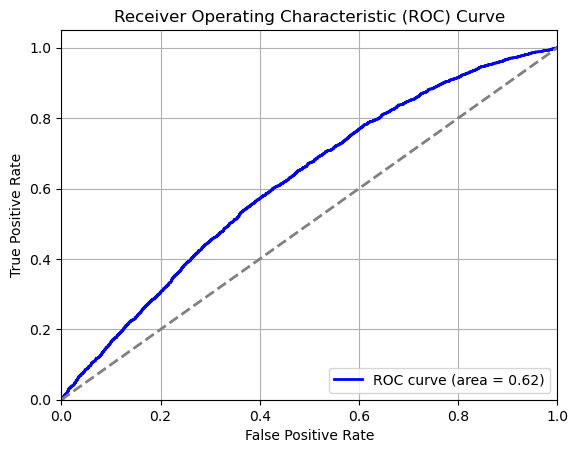

ROC AUC Score: 0.62


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Assuming you have a trained model and test data (X_test, y_test)
# Replace these with your actual data and model
# Example: model = LogisticRegression().fit(X_train, y_train)
# Example: y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute predicted probabilities (for the positive class)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.2f}')


### 2.8.2 Evaluating a Regression Model

When dealing with numerical target variables (regression problems), different evaluation metrics are used compared to classification problems. Here's how you can evaluate a regression model:

#### Popular metrics:

1.  **Mean Absolute Error (MAE)**
2.  **Mean Squared Error (MSE)**
3.  **Root Mean Squared Error (RMSE)**
4.  **R-squared (R²)**
5.  **Adjusted R-squared**:
    -   Adjusts the R² value for the number of predictors, penalizing for unnecessary predictors.
    -   Useful in comparing models with different numbers of predictors.

Useful links:
- [Medium article](https://medium.com/@brandon93.w/regression-model-evaluation-metrics-r-squared-adjusted-r-squared-mse-rmse-and-mae-24dcc0e4cbd3)
- [Python implementation](https://scikit-learn.org/stable/modules/model_evaluation.html) (and formulas)

#### Example:

Let's assume you built a regression model to predict house prices. You would evaluate the model using these metrics:

```python
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# True vs Predicted values
y_true = [300000, 450000, 200000, 600000, 350000]
y_pred = [310000, 430000, 220000, 590000, 360000]

# Calculating Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")`

```

3\. Balancing Model Accuracy and Interpretability
--------------------------------------------------------------

### 3.1 The Trade-Off

-   **Model Accuracy**: Complex models like Random Forests and Neural Networks can be highly accurate but difficult to interpret.
-   **Interpretability**: Simpler models like Logistic Regression are easier to understand but might not capture complex patterns.

### 3.2 Explainable AI in Finance

In finance, explainability is crucial due to regulatory requirements and the need for stakeholder trust. Models should not only be accurate but also transparent. See more on this [Deloitte article](https://www2.deloitte.com/us/en/insights/industry/financial-services/explainable-ai-in-banking.html).

### 3.3 Common challenges

-   **Imbalanced Data**: When one class dominates the dataset, leading to biased predictions.
-   **Overfitting**: When the model performs well on training data but poorly on unseen data.


## 4. Handling Imbalanced Data
Imbalanced data, where one class is underrepresented, is common in finance (e.g., fraud detection, complaints, etc.). Techniques to address this include both oversampling of minority class (recommended), and undersampling or majority class.   

Popular techniques for oversampling include SMOTE, which leverages synthetic data generation to generate more observations that 'look like' the minority class, which can help the model achieve better prediction outcomes.  See more info and methodologies [here](https://medium.com/@abdallahashraf90x/oversampling-for-better-machine-learning-with-imbalanced-data-68f9b5ac2696)

### 4.1 - Handling imbalanced data using SMOTE  
Python code implementation below.

```python
from imblearn.over_sampling import SMOTE

X = df.drop('target', axis=1)  
y = df['target']  

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)  
```






In [16]:
y.value_counts()

loan_default
False    87616
True     12384
Name: count, dtype: int64

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


In [18]:
y_resampled.value_counts()

loan_default
False    87616
True     87616
Name: count, dtype: int64

5\. Overfitting and Cross-validation
-------------------------------------------------

### 5.1 What is Overfitting?

Overfitting occurs when a model captures noise or irrelevant patterns in the training data, leading to poor generalization on new data.

E.g.: [How to fit an elephant?](https://kourentzes.com/forecasting/2016/02/08/how-to-fit-an-elephant/)

### 5.2 Cross-Validation

Cross-validation is a technique where the data is split into several folds, and the model is trained and evaluated on different combinations of these folds. This helps in assessing the model's generalization performance.

**Example**: 5-Fold Cross-Validation

In [19]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')


c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Validation Accuracy Scores: [0.8762  0.87615 0.876   0.87615 0.87615]
Mean CV Accuracy: 0.8761299999999999


6\. Assignment Overview
-----------------------------------

### 6.1 Assignment: Build a Baseline Model

### Objective:
You will enhance the classification model previously built in the session to predict loan defaults using the Lending Club dataset. Please use the 100k row sample as starting point for your model.  

#### Part 1 - Mandatory
Build a second model, `model_2`:
- selecting additional variables
- performing feature engineering (feel free to use features engineered previously)
- performing cross-validation 
- dealing with class imbalance 
- any additional techniques you would like to add to improve your model, at your discretion 

Compare it to `model` by using the evaluation metrics covered in this session.

#### Part 2 - Optional
As a data scientist working for the business, your objective is to **minimize the average cost of default** and **maximize the average income on loans**. Optimise `model_2` on this basis, leveraging a **custom loss function** (see 7.2 below) and considering the **following information on the cost of misclassifying** unseen observations:
##### Misclassification cost, and importance of False Positives and False Negatives:
-   **False Positives (FP)**: Predicting a loan as default when it is not. This can lead to lost opportunities for the lender since a potentially profitable loan is denied. Given the **FP_cost = 100**, the cost is relatively low, but it can accumulate over multiple instances.

-   **False Negatives (FN)**: Predicting a loan as non-default when it actually defaults. This is much more severe because it results in financial loss to the lender. Given the **FN_cost = 1000**, the cost here is much higher, reflecting the significant impact of a loan defaulting when it was predicted otherwise.


#### Part 3 - Optional
The business also wants you to do a PoC to see if they can predict `loan_amnt` based on the following features (feel free to use additional ones if you would like): `emp_length`,`home_ownership`, `annual_inc`.
Build a brand new regression model, `reg_model`, leveraging `LinearRegression` from `sklearn.linear_model` ( see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html))


### Tips:
-   **Feature Engineering**: Explore new features that might improve model performance. You may want or need to use some of the techniques covered in session 3.
-   **Cross-Validation**: Implement cross-validation to ensure your model does not overfit to the training data.
-   **Threshold Adjustment**: Consider adjusting the decision threshold to balance false positives and false negatives based on the associated costs.

### Deliverables:

-   A Jupyter Notebook containing:
    -   Detailed explanations of feature selection and engineering.
    -   Cross-validation implementation.
    -   Final model performance evaluation using custom loss metrics (FP_cost and FN_cost).
    -   Part 2 (optional): Custom loss function implementation and loss optimisation

Good luck, and remember to focus on minimizing the overall cost while ensuring robust model performance!




### 6.2 Extra learning: custom loss functions
**What is a custom loss function?**
A custom loss function is a user-defined function that specifies how errors should be penalized during model training, tailored to the specific goals or constraints of a problem.
Unlike standard loss functions that might only minimize general error (like MSE or cross-entropy), custom loss functions can assign different weights to different types of errors based on their real-world impact.
For instance, you might want to penalize loan defaults more heavily than missed profit opportunities, ensuring that the model's predictions align with the financial implications of errors.

**Implementation in Python (logistic regression)**
In scikit-learn, you cannot directly minimize a custom loss function during the training of a logistic regression model because it uses predefined loss functions like log loss (cross-entropy) during optimization.

You can only adjust the model after training by fine-tuning thresholds based on your custom loss, for example:
```python
# Train logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Predictions
y_pred_prob = model.predict_proba(X)[:, 1]
threshold = 0.5  # Default threshold

# Custom thresholding based on custom loss function
FP_cost = 1.0  # Cost for False Positive
FN_cost = 5.0  # Cost for False Negative

def custom_threshold(y_pred_prob, threshold):
    return np.where(y_pred_prob > threshold, 1, 0)

def evaluate_custom_loss(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    loss = FP_cost * fp + FN_cost * fn
    return loss

# Calculate loss for the default threshold
y_pred_default = custom_threshold(y_pred_prob, threshold)
default_loss = evaluate_custom_loss(y, y_pred_default)

print(f"Default Loss: {default_loss}")
```

While, as seen, you cannot minimize a custom loss function at training time for logistic regressions, you can work around this limitation by using Python loops to evaluate different models or thresholds and select the one with the lowest loss.


```python
# Train logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Predictions probabilities
y_pred_prob = model.predict_proba(X)[:, 1]

# Custom loss function
FP_cost = 100  # Cost for False Positive
FN_cost = 1000  # Cost for False Negative

def custom_loss(y_true, y_pred, threshold):
    y_pred_bin = (y_pred > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    return FP_cost * fp + FN_cost * fn

# Evaluate model for various thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
losses = [custom_loss(y, y_pred_prob, t) for t in thresholds]

# Select the threshold with the minimum loss
best_threshold = thresholds[np.argmin(losses)]
best_loss = min(losses)

print(f"Best Threshold: {best_threshold}")
print(f"Lowest Custom Loss: {best_loss}")
```

**Tip**: Spend some time to get familiar with the code above and test out step by step in separate cells.

## Homework Part 1: 

In [20]:
y_test_mdl1 = y_test.copy()
X_test_mdl1 = X_test.copy()
# Imports
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

df_explore = pd.read_csv("../data/2-intermediate/df_out_dsif5.csv")
df_explore.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,debt_to_income,loan_amnt_log,grade_encoded,term_numeric,interest_per_loan_amnt,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm,loan_default
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,B5,cashier,10+ years,MORTGAGE,48000.0,Source Verified,Mar-2020,Current,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.950000,266.95,183.66,83.29,0.0,0.0,0.0,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,4.912140,134.93,167338079,cashier,False,NaN,NaN,0.1308,0.083333,8.294300,1,36,1569.6,-1.196895,-0.367206,0.083969,0.004364,False
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,B2,ABM,6 years,RENT,57000.0,Source Verified,Feb-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,708xx,LA,25.33,0.0,Jan-2004,680.0,684.0,0.0,NaN,NaN,10.0,0.0,22697.0,64.5%,24.0,w,4333.29,4333.29,25496.160000,25496.16,19666.71,5829.45,0.0,0.0,0.0,May-2020,500.07,Jun-2020,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,61815.0,0.0,3.0,0.0,3.0,14.0,39118.0,72.0,1.0,1.0,2137.0,67.0,

In [21]:
# For now, I'll add a few more features to the model and use a different model besides Logistic Regression
# we are going to look at the new features such as: grade, verification_status, home_ownership
# Encode some categorical variables
df_explore = pd.get_dummies(df_explore, columns=['grade', 'verification_status', 'home_ownership' ], drop_first=True)


In [22]:
df_explore.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,emp_length,annual_inc,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,debt_to_income,loan_amnt_log,grade_encoded,term_numeric,interest_per_loan_amnt,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm,loan_default,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status_Source Verified,verification_status_Verified,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B5,cashier,10+ years,48000.0,Mar-2020,Current,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.950000,266.95,183.66,83.29,0.0,0.0,0.0,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,4.912140,134.93,167338079,cashier,False,NaN,NaN,0.1308,0.083333,8.294300,1,36,1569.6,-1.196895,-0.367206,0.083969,0.004364,False,True,False,False,False,False,False,True,False,True,False,False,False,False
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B2,ABM,6 years,57000.0,Feb-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,708xx,LA,25.33,0.0,Jan-2004,680.0,684.0,0.0,NaN,NaN,10.0,0.0,22697.0,64.5%,24.0,w,4333.29,4333.29,2

In [23]:
# Note that when we use get_dummies, we have 1 columns that we dropped to avoid multicollinearity. Specifically, we need to drop one column from each of the category.
# Notice that grad_A, verification_status_Not Verified, and home_ownership_ANY are not present in the dataframe. This is because they are the base categories and are represented by the absence of the other columns.
features_explore = ['fico_range_high', 'fico_range_low', 'annual_inc', 'dti', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'verification_status_Source Verified', 'verification_status_Verified', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT']
target = ['loan_default']

X_explore = df_explore[features_explore]
y_explore = df_explore[target]


In [24]:
# Create an imputer (replace missing values with the mean of the column)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer
X_explore = imputer.fit_transform(X_explore)

In [25]:
# Count number of each class
y_explore.loan_default.value_counts()   

loan_default
False    87616
True     12384
Name: count, dtype: int64

In [26]:
# Let's try to balance the classes using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_explore, y_explore)

In [27]:
y_resampled.loan_default.value_counts()

loan_default
False    87616
True     87616
Name: count, dtype: int64

In [28]:
# Now we can split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [29]:
# We are going to use a Random Forest model and use Cross-Validation to evaluate the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model2 = RandomForestClassifier()

model2.fit(X_train, y_train)

# Predict on the test set
predictions = model2.predict(X_test)

c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [30]:
# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Confusion Matrix:\n{cm}')

# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(model2, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')


Accuracy: 0.9163123805175907
Precision: 0.9563529338092555
Recall: 0.8722869545350697
F1-Score: 0.9123876094034711
ROC-AUC: 0.9509147605682525
Confusion Matrix:
[[16842   697]
 [ 2236 15272]]


c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed whe

Cross-Validation Accuracy Scores: [0.66088396 0.96995463 0.96929749 0.97041032 0.97001084]
Mean CV Accuracy: 0.9081114487325903


There seems to be a problem in the first fold which prompt me to want to check it. I suspect the SMOTE method might introduce some issue.

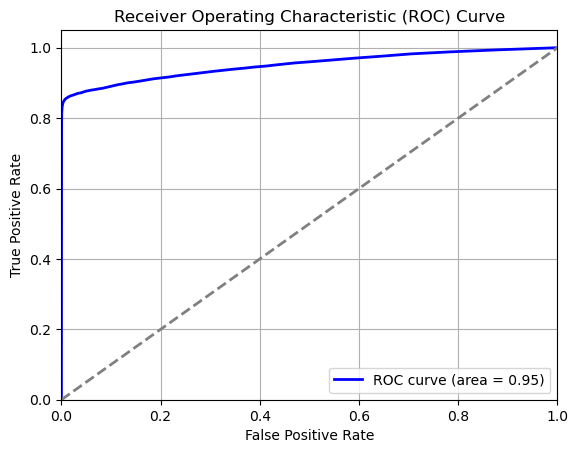

In [31]:
# Let's plot the ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute predicted probabilities (for the positive class)
y_pred_prob = model2.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Compare to Model 1 (Logistics):

In [34]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

# Predict on the test set
predictions = model_1.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model_1.predict_proba(X_test)[:,1])

# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Confusion Matrix:\n{cm}')

c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6393699888720861
Precision: 0.6365471983846542
Recall: 0.6482179575051406
F1-Score: 0.6423295695729688
ROC-AUC: 0.6833336127458918
Confusion Matrix:
[[11059  6480]
 [ 6159 11349]]


c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


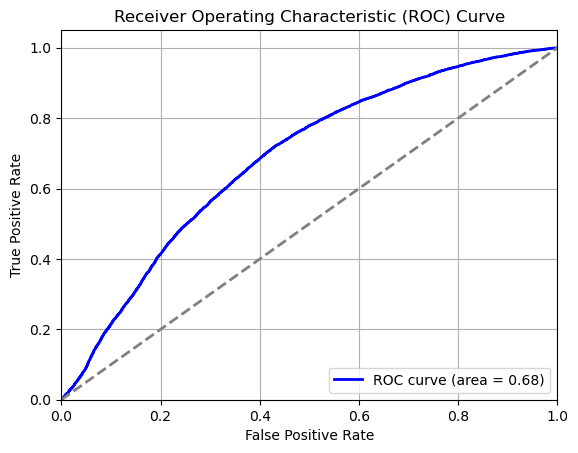

In [ ]:
# Compute predicted probabilities (for the positive class)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Basically quite an improvement from our old model 1 but RF has high potential to overfit.

## Part 2 Custom Lost function:

In [40]:
# Predictions probabilities
y_pred_prob = model2.predict_proba(X_test)[:, 1]

# Custom loss function
FP_cost = 100  # Cost for False Positive - Lost opportunities for the lender to make money
FN_cost = 1000  # Cost for False Negative - Lost money for the lender (more severe)

def custom_loss(y_true, y_pred, threshold):
    y_pred_bin = (y_pred > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    return FP_cost * fp + FN_cost * fn

# Evaluate model for various thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
losses = [custom_loss(y_test, y_pred_prob, t) for t in thresholds]

# Select the threshold with the minimum loss
best_threshold = thresholds[np.argmin(losses)]
best_loss = min(losses)

print(f"Best Threshold: {best_threshold}")
print(f"Lowest Custom Loss: {best_loss}")

Best Threshold: 0.1
Lowest Custom Loss: 1643500


This basically means, that we have a really really strict threshold at the bottom to minimise the custom loss function. Since FN_cost is 10 times more costly than FP_cost. Hence, we are setting the model to be a bit more "sensitive" in misclassifying classifying the probability of default (1).

## Part 3 Regression:

In [41]:
## Custom Results function and imports
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model


def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [47]:
# Let's look at our features: employment length, annual income, home ownership, and additionally fico score high and low.
Na_values = df_explore['emp_length'].isnull().sum()
value_counts = df_explore['emp_length'].value_counts()

print(f"Number of NaN values: {Na_values}")
print(f"Value counts:\n{value_counts}")


Number of NaN values: 6950
Value counts:
emp_length
10+ years    32207
< 1 year      9306
2 years       9014
3 years       7862
1 year        6714
5 years       6158
4 years       6009
6 years       4496
7 years       4051
8 years       3919
9 years       3314
Name: count, dtype: int64


We quite a lot of missing values. We might need to understand why is that. Whether it is a data entry error, or perhaps just a 0. In this case, lets create 2 dataframes which one of them, we fill in the values with 0 and another dataframe, we drop these rows. Afterwards, we are going to treat emp_length as categorical since we don't have precise values (eg. 10+ years and <1 years>). Then we train our regression model.

In [51]:
df_explore_zero_filled = df_explore.copy()
df_explore_zero_filled['emp_length'] = df_explore_zero_filled['emp_length'].fillna(0)
df_explore_dropped = df_explore.dropna(subset=['emp_length'])

# Let's encode the home ownership column, and employment length
df_explore_zero_filled = pd.get_dummies(df_explore_zero_filled, columns=['emp_length'], drop_first=True)
df_explore_dropped = pd.get_dummies(df_explore_dropped, columns=['emp_length'], drop_first=True)


In [52]:
df_explore_zero_filled.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,annual_inc,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,debt_to_income,loan_amnt_log,grade_encoded,term_numeric,interest_per_loan_amnt,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm,loan_default,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status_Source Verified,verification_status_Verified,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B5,cashier,48000.0,Mar-2020,Current,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.950000,266.95,183.66,83.29,0.0,0.0,0.0,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,4.912140,134.93,167338079,cashier,False,NaN,NaN,0.1308,0.083333,8.294300,1,36,1569.6,-1.196895,-0.367206,0.083969,0.004364,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,71016917,24000.0,24000.0,240

In [53]:
df_explore_dropped.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,annual_inc,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,hardship_status_filled,last_pymnt_amnt_log,last_pymnt_amnt_capped,loan_id_extracted,emp_title_clean,emp_title_manager,Job Title,Category,int_rate_clean,debt_to_income,loan_amnt_log,grade_encoded,term_numeric,interest_per_loan_amnt,loan_amnt_std,annual_inc_std,loan_amnt_norm,annual_inc_norm,loan_default,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status_Source Verified,verification_status_Verified,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B5,cashier,48000.0,Mar-2020,Current,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.950000,266.95,183.66,83.29,0.0,0.00,0.000,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO_HARDSHIP,4.912140,134.93,167338079,cashier,False,NaN,NaN,0.1308,0.083333,8.294300,1,36,1569.6,-1.196895,-0.367206,0.083969,0.004364,False,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,

In [55]:
# Features: employment length, annual income, home ownership, and additionally fico score high and low
features_zero_filled = ['fico_range_high', 'fico_range_low', 'annual_inc', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year']
features_dropped = ['fico_range_high', 'fico_range_low', 'annual_inc', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year']
target = ['loan_amnt']

X_zero_filled = df_explore_zero_filled[features_zero_filled]
X_dropped = df_explore_dropped[features_dropped]

y_zero_filled = df_explore_zero_filled[target]
y_dropped = df_explore_dropped[target]

In [ ]:
# Let's also do a standardization of the X data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_zero_filled = scaler.fit_transform(X_zero_filled)
X_dropped = scaler.fit_transform(X_dropped)

In [57]:
X_train_zero, X_test_zero, y_train_zero, y_test_zero = train_test_split(X_zero_filled, y_zero_filled, test_size=0.2, random_state=42)
X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped = train_test_split(X_dropped, y_dropped, test_size=0.2, random_state=42)


model_zero_filled = linear_model.LinearRegression()
model_dropped = linear_model.LinearRegression()

model_zero_filled.fit(X_zero_filled, y_zero_filled)
model_dropped.fit(X_dropped, y_dropped)

LinearRegression()

In [58]:
# Predict on the test set
predictions_zero = model_zero_filled.predict(X_test_zero)
predictions_dropped = model_dropped.predict(X_test_dropped)

# Calculate metrics
print("Zero Filled")
regression_results(y_test_zero, predictions_zero)
print("\nDropped")
regression_results(y_test_dropped, predictions_dropped)

Zero Filled
explained_variance:  0.0799
mean_squared_log_error:  0.5012
r2:  0.0799
MAE:  7189.405
MSE:  83104388.6333
RMSE:  9116.1608

Dropped
explained_variance:  0.0496
mean_squared_log_error:  0.4845
r2:  0.0496
MAE:  7200.7568
MSE:  86438245.4648
RMSE:  9297.2171


# End of session

In [ ]:
from IPython.display import Image
Image(filename=f"{path_python_material}/images/the-end.jpg", width=500,)
